In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error as mse

from math import sqrt

import acquire, prep

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rc('figure', figsize=(14,8))
pd.options.display.float_format = '{:.2f}'.format

In [3]:
df_orig = acquire.get_clean_data()

In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Data columns (total 13 columns):
sale_amount      913000 non-null float64
sale_id          913000 non-null int64
item_brand       913000 non-null object
item_id          913000 non-null int64
item_name        913000 non-null object
item_price       913000 non-null float64
item_upc12       913000 non-null int64
item_upc14       913000 non-null int64
store_address    913000 non-null object
store_city       913000 non-null object
store_id         913000 non-null int64
store_state      913000 non-null object
store_zipcode    913000 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 97.5+ MB


In [5]:
df_orig['sales_total'] = df_orig.sale_amount * df_orig.item_price

In [6]:
df = df_orig.copy()[['sale_amount','sales_total']]

In [7]:
train = df[:'2016'].resample('M').sum()
test = df['2017':].resample('M').sum()

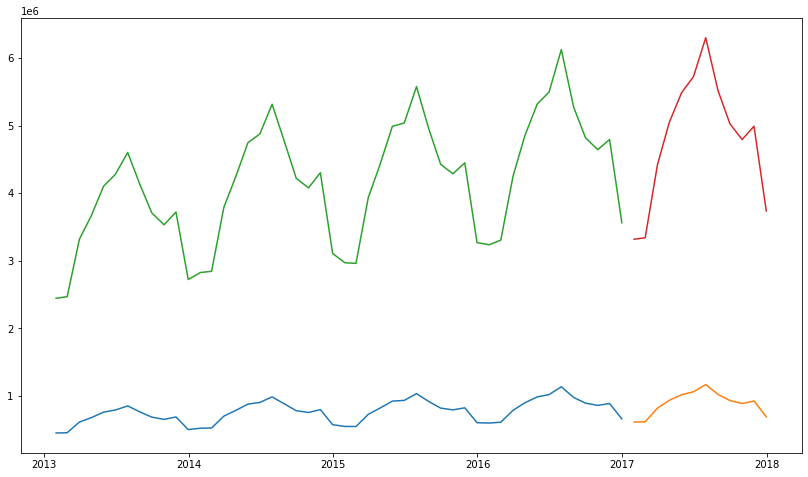

In [8]:
for col in train.columns:
    plt.plot(train[col])
    plt.plot(test[col])

In [9]:
train.tail(1), test.head(1)

(                           sale_amount  sales_total
 sale_date                                          
 2016-12-31 00:00:00+00:00    663411.00   3563185.99,
                            sale_amount  sales_total
 sale_date                                          
 2017-01-31 00:00:00+00:00    617306.00   3319300.40)

In [10]:
train.shape[0], test.shape[0]

(48, 12)

In [11]:
def evaluate(col):
    return sqrt(mse(test[col], yhat_df[col]))

In [12]:
def append_eval_df(model, col):
    rmse = evaluate(col)
    d = pd.DataFrame({
        'model': [model], 
        'variable': [col], 
        'rmse': [rmse]
    })
    return eval_df.append(d, ignore_index=True)

In [13]:
def plot_and_eval(col):

    # plot actual values
    plt.figure(figsize=(12, 4))
    plt.plot(train[col],label = 'Train', linewidth = 1)
    plt.plot(test[col], label = 'Test', linewidth = 1)

    # plot predicted values along with evaluation metric
    rmse = evaluate(col)
    plt.plot(yhat_df[col], linewidth = 1)
    plt.title(col)
    print(col, '-- RMSE: {:.0f}'.format(rmse))
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

In [14]:
eval_df = pd.DataFrame(columns=['model', 'variable', 'rmse'])

### Last Observed

In [15]:
items = train['sale_amount'][-1:][0]
dollars = train['sales_total'][-1:][0]

yhat_df = pd.DataFrame({'sale_amount': [items], 
                        'sales_total': [dollars]}, 
                       index = test.index)
yhat_df.head(3)

,sale_amount,sales_total
sale_date,,
2017-01-31 00:00:00+00:00,663411.00,3563185.99
2017-02-28 00:00:00+00:00,663411.00,3563185.99
2017-03-31 00:00:00+00:00,663411.00,3563185.99


In [16]:
for col in train.columns:
    eval_df = append_eval_df(model='last_observed', col=col)
eval_df  

,model,variable,rmse
0,last_observed,sale_amount,285888.65
1,last_observed,sales_total,1538896.44


sales_total -- RMSE: 1538896


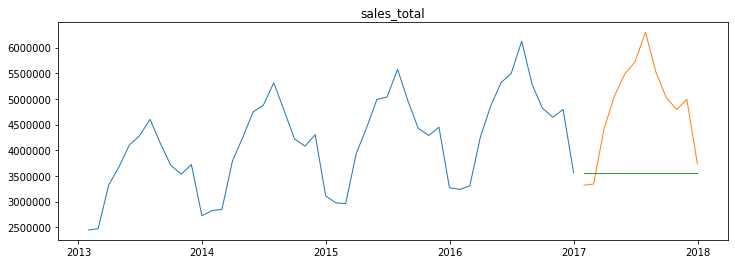

In [17]:
plot_and_eval('sales_total')

### Simple Average

In [18]:
items = train['sale_amount'].mean()
dollars = train['sales_total'].mean()

yhat_df = pd.DataFrame({'sale_amount': [items], 
                        'sales_total': [dollars]}, 
                       index = test.index)
yhat_df.head(3)

,sale_amount,sales_total
sale_date,,
2017-01-31 00:00:00+00:00,770224.42,4140908.90
2017-02-28 00:00:00+00:00,770224.42,4140908.90
2017-03-31 00:00:00+00:00,770224.42,4140908.90


In [19]:
for col in train.columns:
    eval_df = append_eval_df(model='simple_average', col=col)
eval_df

,model,variable,rmse
0,last_observed,sale_amount,285888.65
1,last_observed,sales_total,1538896.44
2,simple_average,sale_amount,209234.90
3,simple_average,sales_total,1124077.81


sales_total -- RMSE: 1124078


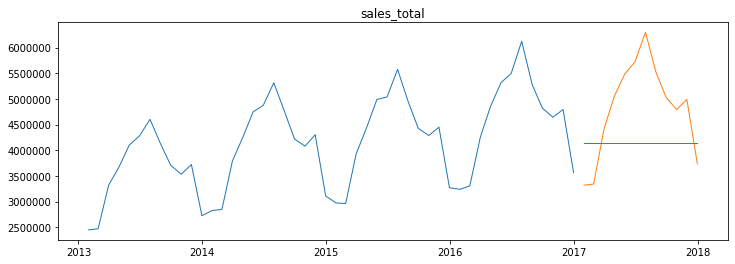

In [20]:
plot_and_eval('sales_total')

### Moving Average

In [21]:
items = train['sale_amount'].rolling(30).mean().iloc[-1]
dollars = train['sales_total'].rolling(30).mean().iloc[-1]

yhat_df = pd.DataFrame({'sale_amount': [items], 
                        'sales_total': [dollars]}, 
                       index = test.index)
yhat_df.head(3)

,sale_amount,sales_total
sale_date,,
2017-01-31 00:00:00+00:00,823049.70,4424649.31
2017-02-28 00:00:00+00:00,823049.70,4424649.31
2017-03-31 00:00:00+00:00,823049.70,4424649.31


In [22]:
for col in train.columns:
    eval_df = append_eval_df(model='moving_average', col=col)
eval_df

,model,variable,rmse
0,last_observed,sale_amount,285888.65
1,last_observed,sales_total,1538896.44
2,simple_average,sale_amount,209234.90
3,simple_average,sales_total,1124077.81
4,moving_average,sale_amount,182872.24
5,moving_average,sales_total,982572.66


sales_total -- RMSE: 982573


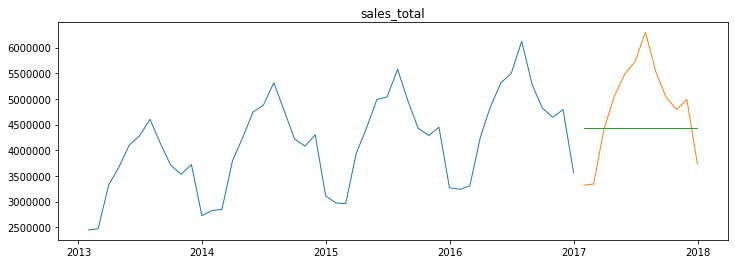

In [23]:
plot_and_eval('sales_total')

### Holt's Linear Trend

In [24]:
# for i in range(3):
#     locals()['x' + str(i)] = i
# x2

In [25]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=.3, smoothing_slope=.1, 
                      optimized=False)
    locals()['yhat_'+str(col)] = model.predict(start=test.index[0], 
                                  end=test.index[-1])

In [26]:
yhat_df = pd.concat([pd.DataFrame(yhat_sale_amount),
                     yhat_sales_total], axis=1)
yhat_df.columns=train.columns
yhat_df.head(3)

,sale_amount,sales_total
2017-01-31 00:00:00+00:00,863566.06,4641033.05
2017-02-28 00:00:00+00:00,863547.00,4640791.09
2017-03-31 00:00:00+00:00,863527.93,4640549.14


In [27]:
for col in train.columns:
    eval_df = append_eval_df(model='holts_trend', col=col)
eval_df

,model,variable,rmse
0,last_observed,sale_amount,285888.65
1,last_observed,sales_total,1538896.44
2,simple_average,sale_amount,209234.90
3,simple_average,sales_total,1124077.81
4,moving_average,sale_amount,182872.24
5,moving_average,sales_total,982572.66
6,holts_trend,sale_amount,171198.61
7,holts_trend,sales_total,920453.47


sales_total -- RMSE: 920453


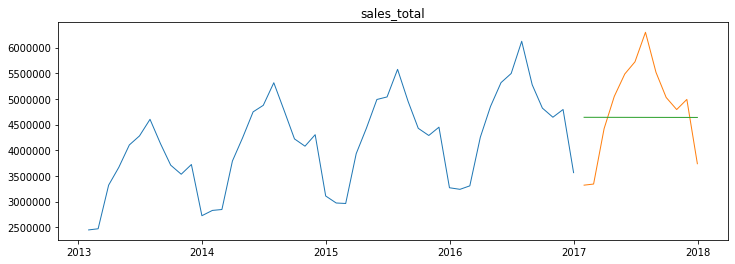

In [28]:
plot_and_eval('sales_total')

### Year Over Year

In [29]:
train.head(1), train.tail(1)

(                           sale_amount  sales_total
 sale_date                                          
 2013-01-31 00:00:00+00:00    454904.00   2447368.20,
                            sale_amount  sales_total
 sale_date                                          
 2016-12-31 00:00:00+00:00    663411.00   3563185.99)

In [30]:
yhat_df = train['2016'] + train.diff(12).mean()
yhat_df.index = test.index

In [31]:
for col in train.columns:
    eval_df = append_eval_df(model='year_over_year', col=col)
eval_df

,model,variable,rmse
0,last_observed,sale_amount,285888.65
1,last_observed,sales_total,1538896.44
2,simple_average,sale_amount,209234.90
3,simple_average,sales_total,1124077.81
4,moving_average,sale_amount,182872.24
5,moving_average,sales_total,982572.66
6,holts_trend,sale_amount,171198.61
7,holts_trend,sales_total,920453.47
8,year_over_year,sale_amount,37240.02
9,year_over_year,sales_total,199926.05


sales_total -- RMSE: 199926


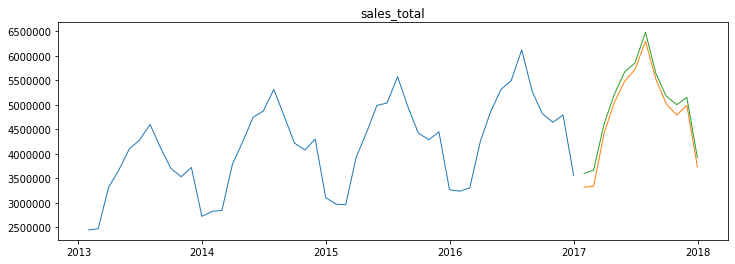

In [32]:
plot_and_eval('sales_total')

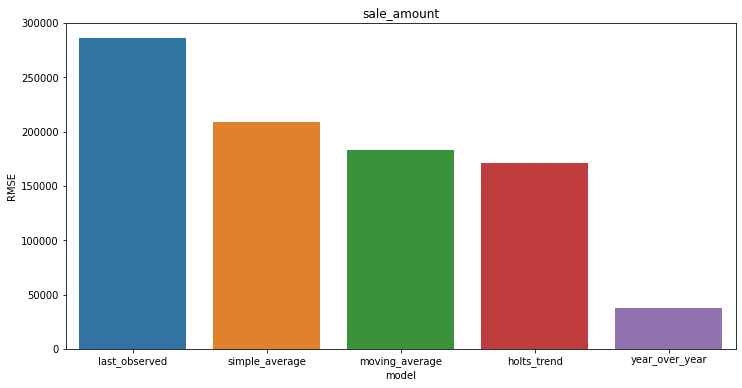

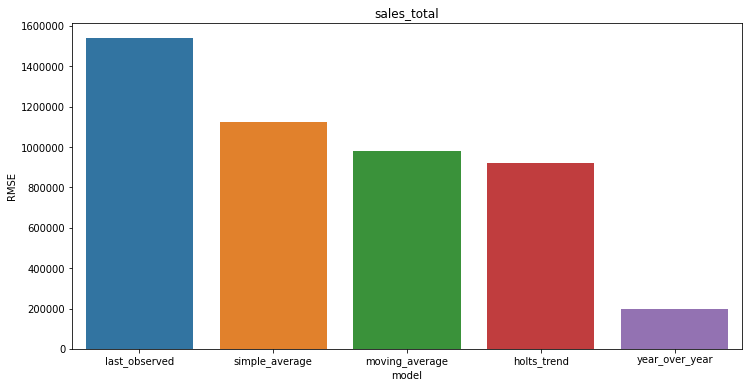

In [34]:
for col in train.columns:
    x = eval_df[eval_df['variable'] == col]['model']
    y = eval_df[eval_df['variable'] == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()